<a href="https://colab.research.google.com/github/ganeshhep/FCC/blob/main/comparison_strange_frag_tag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastjet
!pip install uproot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.4/871.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.9 MB/s eta 0:00:00


In [2]:
import uproot
import awkward as ak
import itertools
from fastjet import PseudoJet, JetDefinition, ClusterSequence, antikt_algorithm, sorted_by_pt
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_file_1 = '/content/drive/MyDrive/ML_HEP/Data_files/fcc_ee_h_ss.root'
data_file_2 = '/content/drive/MyDrive/ML_HEP/Data_files/fcc_ee_h_qq.root'
tree_1 = uproot.open(data_file_1)['events']
tree_2 = uproot.open(data_file_2)['events']

Mounted at /content/drive


In [4]:
pid = ak.concatenate([tree_1['Particle.PDG'].array(), tree_2['Particle.PDG'].array()], axis = 0)
p_status = ak.concatenate([tree_1['Particle.generatorStatus'].array(), tree_2['Particle.generatorStatus'].array()], axis = 0)
charge = ak.concatenate([tree_1['Particle.charge'].array(), tree_2['Particle.charge'].array()], axis = 0)
m = ak.concatenate([tree_1['Particle.mass'].array(), tree_2['Particle.mass'].array()], axis = 0)
px = ak.concatenate([tree_1['Particle.momentum.x'].array(), tree_2['Particle.momentum.x'].array()], axis = 0)
py = ak.concatenate([tree_1['Particle.momentum.y'].array(), tree_2['Particle.momentum.y'].array()], axis = 0)
pz = ak.concatenate([tree_1['Particle.momentum.z'].array(), tree_2['Particle.momentum.z'].array()], axis = 0)
p_begin = ak.concatenate([tree_1['Particle.parents_begin'].array(), tree_2['Particle.parents_begin'].array()], axis = 0)
p_end = ak.concatenate([tree_1['Particle.parents_end'].array(), tree_2['Particle.parents_end'].array()], axis = 0)
p_ind = ak.concatenate([tree_1['Particle#0.index'].array(), tree_2['Particle#0.index'].array()], axis = 0)

In [5]:
# Function to calculate energy
def energy(m, px, py, pz):
    E = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return E

In [6]:
e = energy(m, px, py, pz) # Energy of particles

In [7]:
def get_parent_ids(i, particle_ids, parent_indices, parents_begin, parents_end) :
    """
    Find parent ID and it's index in the particle IDs list.

    Parameters:
        i (integer): Index of the stable particle.
        particle_ids (list): A list of IDs of particles.
        parent_indices (list): A list of parent indices of particles.
        parents_begin (list): A list of indices of the first parent of each particle.
        parents_end (list): A list of indices of the last parent of each particle.

    Returns:
        parent_id (integer): Parent ID of the stable particle.
        parent_indx (integer): Index of the parent particle.

    """
    pb = parents_begin[i]
    pe = parents_end[i]

    if pb == pe :
      return 0
    else :
      for id in range(pb, pe) :
        parent_indx = parent_indices[id]
      return parent_indx

In [8]:
def find_parent_and_daughter_ids(indices, particle_ids, all_particle_ids):
    """
    Find parent IDs and corresponding daughter IDs for each repeated index.

    Parameters:
        indices (list): A list of parent indices of stable particles.
        particle_ids (list): A list of IDs of stable particles.
        all_particle_ids (list): A list of all particle IDs.

    Returns:
        list: [[parent index, parent ID, list of daughter IDs],...,....].
    """
    # Count occurrences of each index
    counts = Counter(indices)

    # Identify repeated indices
    repeated_indices = {index for index, count in counts.items() if count >= 2}

    # Collect parent and daughter IDs for repeated indices
    parent_daughters = []
    for index in repeated_indices:
        parent_id = all_particle_ids[index]  # Get the parent ID using the index
        daughters = [particle_ids[i] for i in range(len(indices)) if indices[i] == index]
        parent_daughters.append([index, parent_id, daughters])

    return parent_daughters

In [9]:
def get_graph_list(R) : # R is the radius parameter
  d1_pt = []
  d1_eta = []
  d1_e = []
  d1_N = []
  photon_e_1 = []
  muon_e_1 = []
  electron_e_1 = []
  Ks_e_1 = []
  lambda_e_1 = []
  lambdabar_e_1 = []
  photon_cnt_1 = []
  muon_cnt_1 = []
  electron_cnt_1 = []
  Ks_cnt_1 = []
  lambda_cnt_1 = []
  lambdabar_cnt_1 = []
  mes_cnt_1 = []
  bar_cnt_1 = []

  d2_pt = []
  d2_eta = []
  d2_e = []
  d2_N = []
  photon_e_2 = []
  muon_e_2 = []
  electron_e_2 = []
  Ks_e_2 = []
  lambda_e_2 = []
  lambdabar_e_2 = []
  photon_cnt_2 = []
  muon_cnt_2 = []
  electron_cnt_2 = []
  Ks_cnt_2 = []
  lambda_cnt_2 = []
  lambdabar_cnt_2 = []
  mes_cnt_2 = []
  bar_cnt_2 = []

  for n in range(100000):
    particles_list_1 = [] # A list of all the particles in an event

    constituent_indx_1 = [] # A list of indices of constitents of the dijet

    parent_indices_1 = [] # A list of parent indices of constitents of the dijet

    photon_energy_1 = 0 # Total photon energy
    muon_energy_1 = 0 # Total muon energy
    electron_energy_1 = 0 # Total electron energy
    Ks_energy_1 = 0 # Total reconstructed Ks meson energy
    lambda_energy_1 = 0 # Total reconstructed lambda baryon energy
    lambdabar_energy_1 = 0 # Total reconstructed lambdabar baryon energy

    photon_count_1 = 0 # Photon count
    muon_count_1 = 0 # Muon count
    electron_count_1 = 0 # Electron count
    lambda_count_1 = 0 # Lambda baryon count
    lambdabar_count_1 = 0 # Lambdabar baryon count
    Ks_count_1 = 0 # Ks meson count

    sts_1 = p_status[n] # Generator status of particles
    p_x_1 = px[n] # X-momentum of particles
    p_y_1 = py[n] # Y-momentum of particles
    p_z_1 = pz[n] # Z-momentum of particles
    E_1 = e[n] # Energy of particles
    pcharge = charge[n] # Charge of particles
    ids_1 = pid[n] # PDG id of particles
    pinds_1 = p_ind[n] # Parent indices of particles
    pbegin_1 = p_begin[n] # Parent begin indices of particles
    pend_1 = p_end[n] # Parent end indices of particles

    for i in range(len(p_x_1)) :
      part_p4_1 = PseudoJet(float(p_x_1[i]), float(p_y_1[i]), float(p_z_1[i]), float(E_1[i]))
      part_p4_1.set_user_index(i) # setting the index of the particle
      particles_list_1.append(part_p4_1)

    stable_p4_1 = [] # A list of stable particles in the event

    for i in range(len(particles_list_1)) :
      if sts_1[i] == 1 :
        stable_p4_1.append(particles_list_1[i])

    # Applying clustering of particles with anti-kt algorithm
    cluster_1 = ClusterSequence(stable_p4_1, JetDefinition(antikt_algorithm, R))
    jet_set_1 = sorted_by_pt(cluster_1.inclusive_jets())

    if len(jet_set_1) > 1 :
      # Dijet kinematics
      dijet_1 = jet_set_1[0] + jet_set_1[1]
      d_m_1 = dijet_1.m() # invariant mass
      d_pt_1 = dijet_1.pt() # transverse momentum
      d_eta_1 = dijet_1.eta() # pseudo rapidity
      d_e_1 = dijet_1.e() # energy

      Dijet_constituents_1 = jet_set_1[0].constituents() + jet_set_1[1].constituents() # Dijet constituents

      N_constituents_1 = len(Dijet_constituents_1) # Total number of constituents N in the dijet

      d1_pt.append(d_pt_1)
      d1_eta.append(d_eta_1)
      d1_e.append(d_e_1)
      d1_N.append(N_constituents_1)

      for i in range(N_constituents_1) :
        constituent_indx_1.append(Dijet_constituents_1[i].user_index())

      constituent_ids_1 = ids_1[constituent_indx_1]

      for j in constituent_indx_1 :
        const_id_1 = ids_1[j]

        if const_id_1 == 22 :
          photon_count_1 += 1
          photon_energy_1 += particles_list_1[j].e()
        if const_id_1 == 13 :
          muon_count_1 += 1
          muon_energy_1 += particles_list_1[j].e()
        if const_id_1 == 11 :
          electron_count_1 += 1
          electron_energy_1 += particles_list_1[j].e()

        parent_indx_1 = get_parent_ids(j, ids_1, pinds_1, pbegin_1, pend_1)
        parent_indices_1.append(parent_indx_1)

        parent_id_1 = ids_1[parent_indx_1]

      pd_1 = find_parent_and_daughter_ids(parent_indices_1, constituent_ids_1, ids_1)

      mes_count_1 = 0 # Strange meson count
      bar_count_1 = 0 # Strange baryon count

      for k in range(len(pd_1)) :
        pd_indx_1 = pd_1[k][0]
        pd_id_1 = pd_1[k][1]

        if pd_id_1 == 310 :
          Ks_count_1 += 1
          mes_count_1 += 1
          Ks_energy_1 += particles_list_1[pd_indx_1].e()
        if pd_id_1 == 3122 :
          lambda_count_1 += 1
          bar_count_1 += 1
          lambda_energy_1 += particles_list_1[pd_indx_1].e()
        if pd_id_1 == -3122 :
          lambdabar_count_1 += 1
          bar_count_1 += 1
          lambdabar_energy_1 += particles_list_1[pd_indx_1].e()

      photon_e_1.append(photon_energy_1)
      muon_e_1.append(muon_energy_1)
      electron_e_1.append(electron_energy_1)
      Ks_e_1.append(Ks_energy_1)
      lambda_e_1.append(lambda_energy_1)
      lambdabar_e_1.append(lambdabar_energy_1)

      photon_cnt_1.append(photon_count_1)
      muon_cnt_1.append(muon_count_1)
      electron_cnt_1.append(electron_count_1)
      Ks_cnt_1.append(Ks_count_1)
      lambda_cnt_1.append(lambda_count_1)
      lambdabar_cnt_1.append(lambdabar_count_1)

      mes_cnt_1.append(mes_count_1)
      bar_cnt_1.append(bar_count_1)

    particles_list_2 = [] # A list of all the particles in an event

    constituent_indx_2 = [] # A list of indices of constitents of the dijet

    parent_indices_2 = [] # A list of parent indices of constitents of the dijet

    photon_energy_2 = 0 # Total photon energy
    muon_energy_2 = 0 # Total muon energy
    electron_energy_2 = 0 # Total electron energy
    Ks_energy_2 = 0 # Total reconstructed Ks meson energy
    lambda_energy_2 = 0 # Total reconstructed lambda baryon energy
    lambdabar_energy_2 = 0 # Total reconstructed lambdabar baryon energy

    photon_count_2 = 0 # Photon count
    muon_count_2 = 0 # Muon count
    electron_count_2 = 0 # Electron count
    lambda_count_2 = 0 # Lambda baryon count
    lambdabar_count_2 = 0 # Lambdabar baryon count
    Ks_count_2 = 0 # Ks meson count

    sts_2 = p_status[100000 + n] # Generator status of particles
    p_x_2 = px[100000 + n] # X-momentum of particles
    p_y_2 = py[100000 + n] # Y-momentum of particles
    p_z_2 = pz[100000 + n] # Z-momentum of particles
    E_2 = e[100000 + n] # Energy of particles
    ids_2 = pid[100000 + n] # PDG id of particles
    pinds_2 = p_ind[100000 + n] # Parent indices of particles
    pbegin_2 = p_begin[100000 + n] # Parent begin indices of particles
    pend_2 = p_end[100000 + n] # Parent end indices of particles

    for i in range(len(p_x_2)) :
      part_p4_2 = PseudoJet(float(p_x_2[i]), float(p_y_2[i]), float(p_z_2[i]), float(E_2[i]))
      part_p4_2.set_user_index(i) # setting the index of the particle
      particles_list_2.append(part_p4_2)

    stable_p4_2 = [] # A list of stable particles in the event

    for i in range(len(particles_list_2)) :
      if sts_2[i] == 1 :
        stable_p4_2.append(particles_list_2[i])

    # Applying clustering of particles with anti-kt algorithm
    cluster_2 = ClusterSequence(stable_p4_2, JetDefinition(antikt_algorithm, R))
    jet_set_2 = sorted_by_pt(cluster_2.inclusive_jets())

    if len(jet_set_2) > 1 :
      # Dijet kinematics
      dijet_2 = jet_set_2[0] + jet_set_2[1]
      d_m_2 = dijet_2.m() # invariant mass
      d_pt_2 = dijet_2.pt() # transverse momentum
      d_eta_2 = dijet_2.eta() # pseudo rapidity
      d_e_2 = dijet_2.e() # energy

      Dijet_constituents_2 = jet_set_2[0].constituents() + jet_set_2[1].constituents() # Dijet constituents

      N_constituents_2 = len(Dijet_constituents_2) # Total number of constituents N in the dijet

      d2_pt.append(d_pt_2)
      d2_eta.append(d_eta_2)
      d2_e.append(d_e_2)
      d2_N.append(N_constituents_2)

      for i in range(N_constituents_2) :
        constituent_indx_2.append(Dijet_constituents_2[i].user_index())

      constituent_ids_2 = ids_2[constituent_indx_2]

      for j in constituent_indx_2 :
        const_id_2 = ids_2[j]

        if const_id_2 == 22 :
          photon_count_2 += 1
          photon_energy_2 += particles_list_2[j].e()
        if const_id_2 == 13 :
          muon_count_2 += 1
          muon_energy_2 += particles_list_2[j].e()
        if const_id_2 == 11 :
          electron_count_2 += 1
          electron_energy_2 += particles_list_2[j].e()

        parent_indx_2 = get_parent_ids(j, ids_2, pinds_2, pbegin_2, pend_2)
        parent_indices_2.append(parent_indx_2)

        parent_id_2 = ids_2[parent_indx_2]

      pd_2 = find_parent_and_daughter_ids(parent_indices_2, constituent_ids_2, ids_2)

      mes_count_2 = 0 # Strange meson count
      bar_count_2 = 0 # Strange baryon count

      for k in range(len(pd_2)) :
        pd_indx_2 = pd_2[k][0]
        pd_id_2 = pd_2[k][1]

        if pd_id_2 == 310 :
          Ks_count_2 += 1
          mes_count_2 += 1
          Ks_energy_2 += particles_list_2[pd_indx_2].e()
        if pd_id_2 == 3122 :
          lambda_count_2 += 1
          bar_count_2 += 1
          lambda_energy_2 += particles_list_2[pd_indx_2].e()
        if pd_id_2 == -3122 :
          lambdabar_count_2 += 1
          bar_count_2 += 1
          lambdabar_energy_2 += particles_list_2[pd_indx_2].e()

      photon_e_2.append(photon_energy_2)
      muon_e_2.append(muon_energy_2)
      electron_e_2.append(electron_energy_2)
      Ks_e_2.append(Ks_energy_2)
      lambda_e_2.append(lambda_energy_2)
      lambdabar_e_2.append(lambdabar_energy_2)

      photon_cnt_2.append(photon_count_2)
      muon_cnt_2.append(muon_count_2)
      electron_cnt_2.append(electron_count_2)
      Ks_cnt_2.append(Ks_count_2)
      lambda_cnt_2.append(lambda_count_2)
      lambdabar_cnt_2.append(lambdabar_count_2)

      mes_cnt_2.append(mes_count_2)
      bar_cnt_2.append(bar_count_2)

  return d1_pt, d1_eta, d1_e, d1_N, photon_e_1, muon_e_1, electron_e_1, Ks_e_1, lambda_e_1, lambdabar_e_1, photon_cnt_1, muon_cnt_1, electron_cnt_1, Ks_cnt_1, lambda_cnt_1, lambdabar_cnt_1, mes_cnt_1, bar_cnt_1, d2_pt, d2_eta, d2_e, d2_N, photon_e_2, muon_e_2, electron_e_2, Ks_e_2, lambda_e_2, lambdabar_e_2, photon_cnt_2, muon_cnt_2, electron_cnt_2, Ks_cnt_2, lambda_cnt_2, lambdabar_cnt_2, mes_cnt_2, bar_cnt_2

In [10]:
graph_list = get_graph_list(R = 0.8)

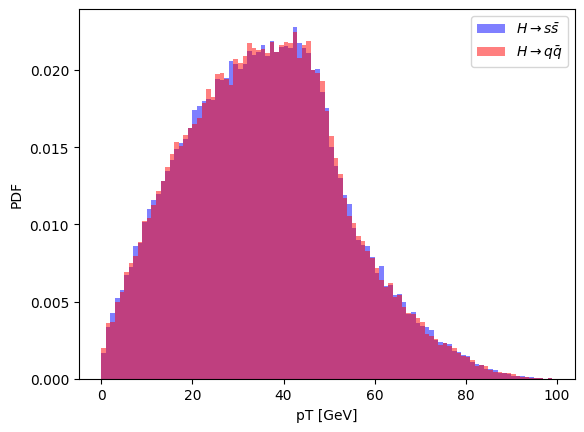

In [71]:
plt.hist(graph_list[0], bins = np.arange(0, 100), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[18], bins = np.arange(0, 100), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("pT [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

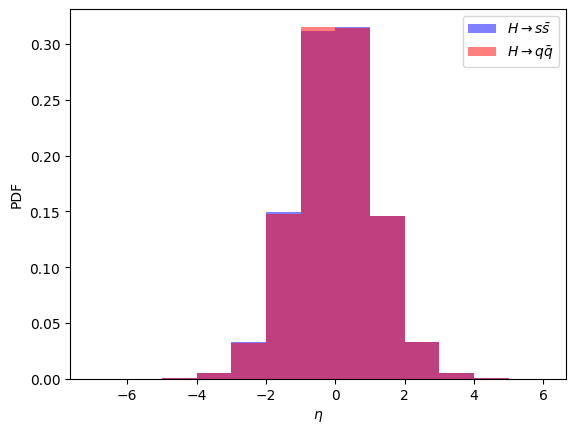

In [72]:
plt.hist(graph_list[1], bins = np.arange(-7, 7), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[19], bins = np.arange(-7, 7), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("$\eta$")
plt.ylabel("PDF")
plt.legend()
plt.show()

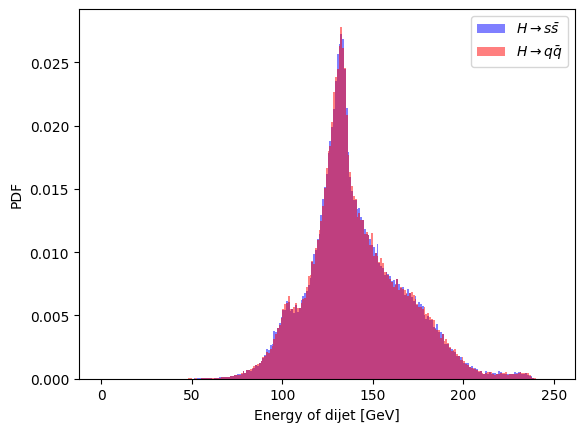

In [74]:
plt.hist(graph_list[2], bins = np.arange(0, 250), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[20], bins = np.arange(0, 250), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of dijet [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

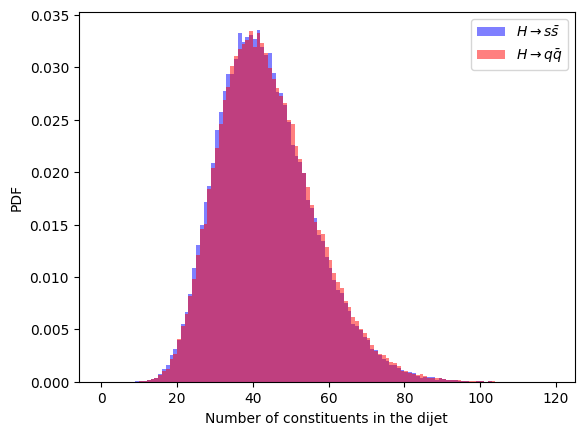

In [77]:
plt.hist(graph_list[3], bins = np.arange(0, 120), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[21], bins = np.arange(0, 120), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of constituents in the dijet")
plt.ylabel("PDF")
plt.legend()
plt.show()

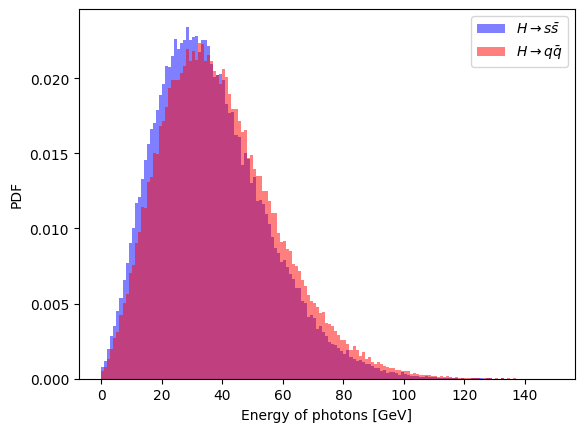

In [78]:
plt.hist(graph_list[4], bins = np.arange(0, 150), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[22], bins = np.arange(0, 150), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of photons [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

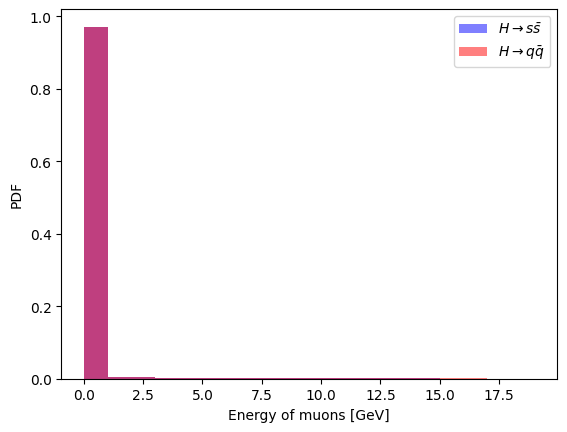

In [79]:
plt.hist(graph_list[5], bins = np.arange(0, 20), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[23], bins = np.arange(0, 20), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of muons [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

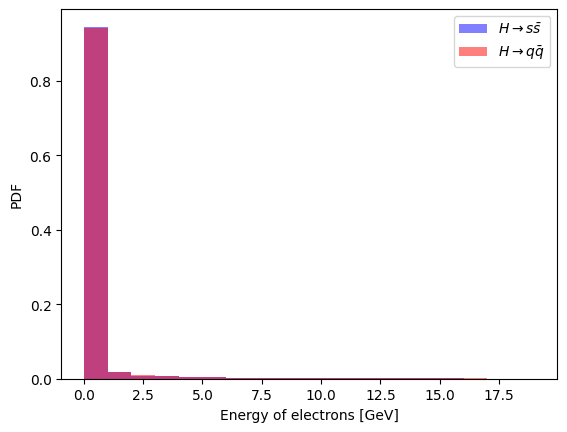

In [80]:
plt.hist(graph_list[6], bins = np.arange(0, 20), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[24], bins = np.arange(0, 20), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of electrons [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

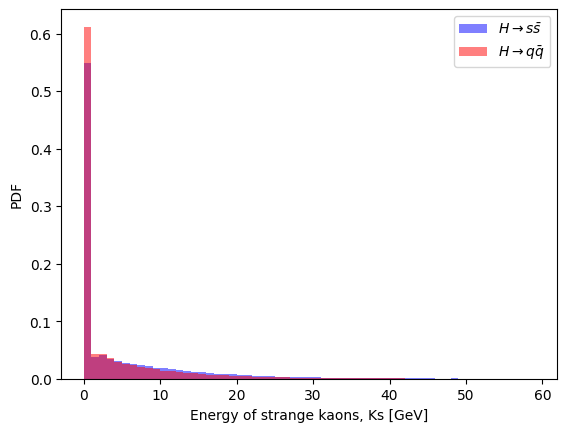

In [81]:
plt.hist(graph_list[7], bins = np.arange(0, 60), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[25], bins = np.arange(0, 60), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of strange kaons, Ks [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

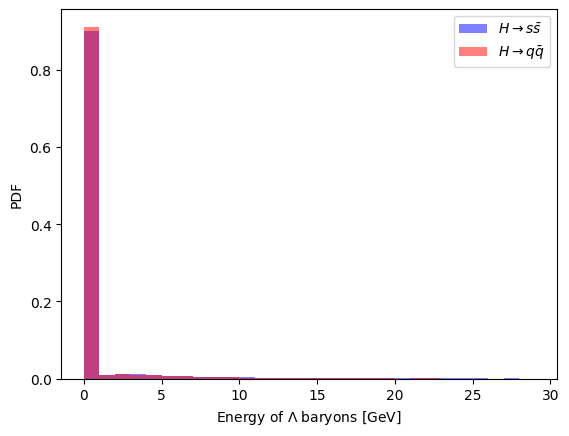

In [82]:
plt.hist(graph_list[8], bins = np.arange(0, 30), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[26], bins = np.arange(0, 30), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of $\Lambda$ baryons [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

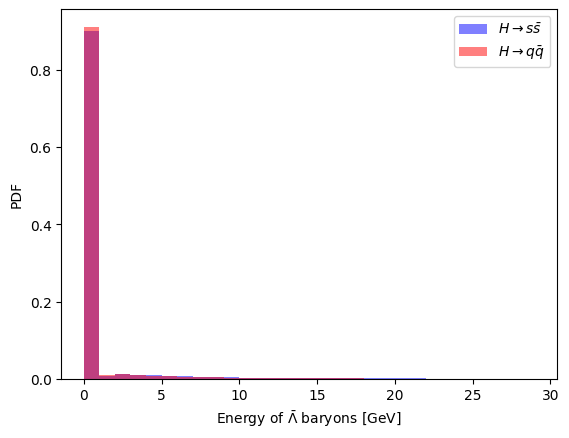

In [87]:
plt.hist(graph_list[9], bins = np.arange(0, 30), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[27], bins = np.arange(0, 30), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel(r"Energy of $\bar{\Lambda}$ baryons [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

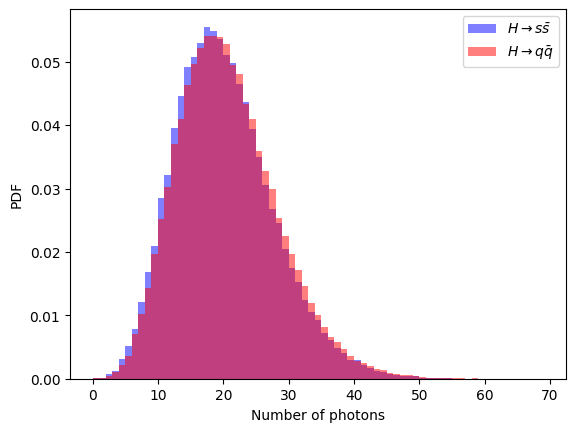

In [88]:
plt.hist(graph_list[10], bins = np.arange(0, 70), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[28], bins = np.arange(0, 70), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of photons")
plt.ylabel("PDF")
plt.legend()
plt.show()

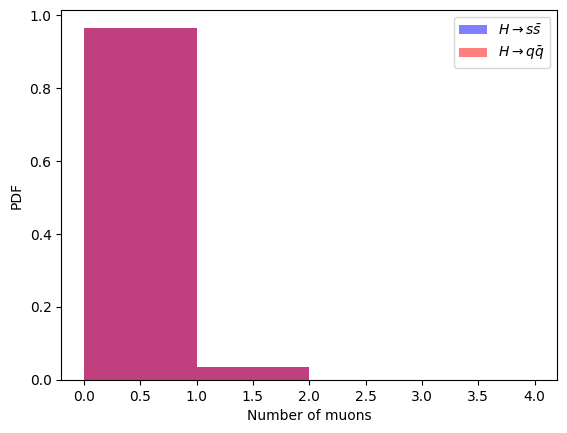

In [89]:
plt.hist(graph_list[11], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[29], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of muons")
plt.ylabel("PDF")
plt.legend()
plt.show()

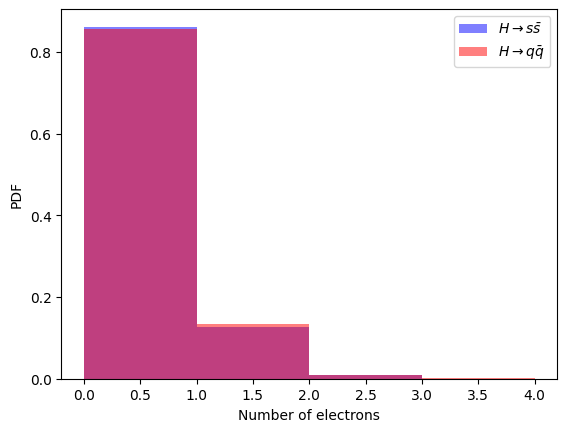

In [90]:
plt.hist(graph_list[12], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[30], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of electrons")
plt.ylabel("PDF")
plt.legend()
plt.show()

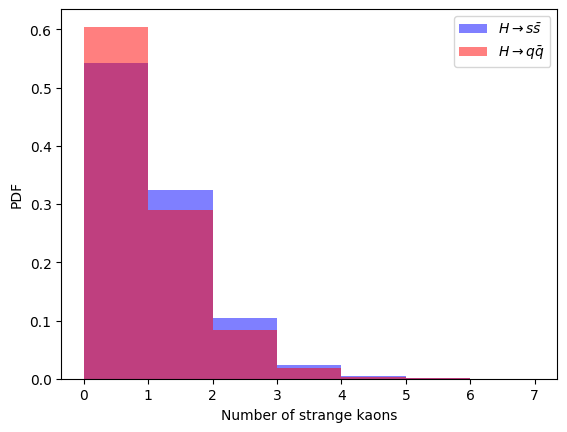

In [91]:
plt.hist(graph_list[13], bins = np.arange(0, 8), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[31], bins = np.arange(0, 8), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of strange kaons")
plt.ylabel("PDF")
plt.legend()
plt.show()

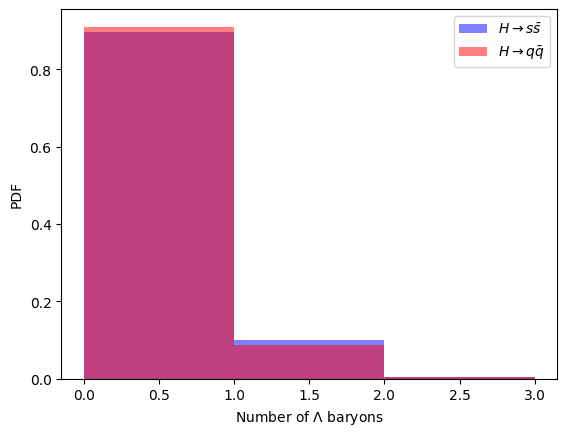

In [92]:
plt.hist(graph_list[14], bins = np.arange(0, 4), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[32], bins = np.arange(0, 4), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of $\Lambda$ baryons")
plt.ylabel("PDF")
plt.legend()
plt.show()

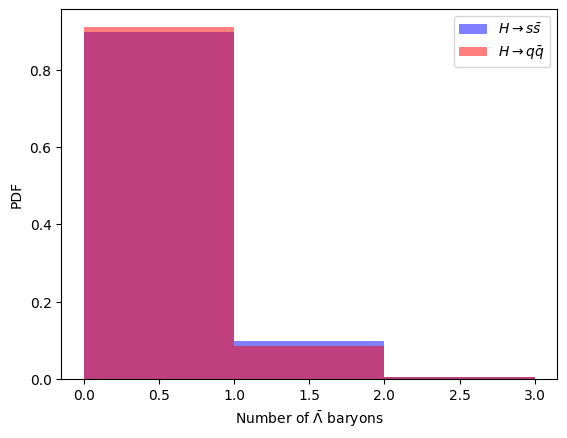

In [94]:
plt.hist(graph_list[15], bins = np.arange(0, 4), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[33], bins = np.arange(0, 4), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel(r"Number of $\bar{\Lambda}$ baryons")
plt.ylabel("PDF")
plt.legend()
plt.show()

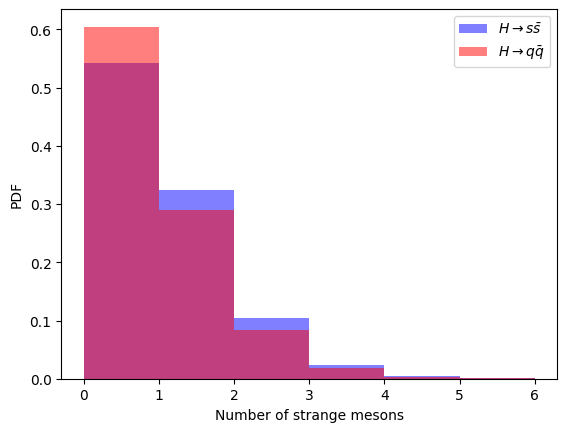

In [95]:
plt.hist(graph_list[16], bins = np.arange(0, 7), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[34], bins = np.arange(0, 7), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of strange mesons")
plt.ylabel("PDF")
plt.legend()
plt.show()

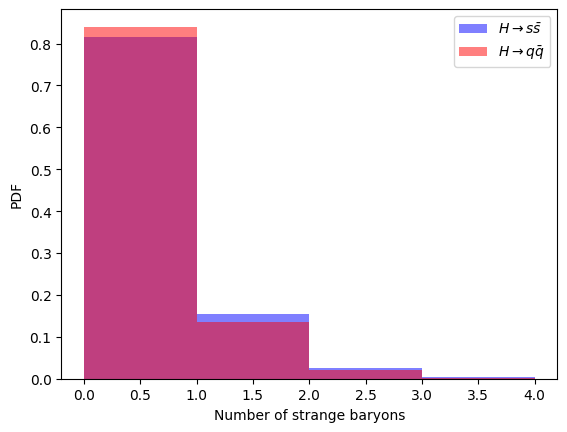

In [96]:
plt.hist(graph_list[17], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(graph_list[35], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of strange baryons")
plt.ylabel("PDF")
plt.legend()
plt.show()